# Organic Vs Recyclable Waste Classification

# Convolutional Neural Network(CNN)

In this notebook we will deal with a dataset containing 25,000 images of waste. Our task is to build a model to classify this waste into organic waste and recyclable waste. We will experiment with CNN classifiers in order to achieve this task

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from custom_cnn import CustomCNN  # Import custom CNN model

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

## Parse Data directories

In [2]:
def get_img_paths(path):
    paths = []
    labels = []
    for label in os.listdir(path):
        img_dir = os.path.join(path, label)
        for img in os.listdir(img_dir):
            paths.append(os.path.join(img_dir, img))
            labels.append(label)

    return pd.DataFrame({'path':paths, 'label':labels})

## Training Paths

In [3]:
train = get_img_paths("F:/UWL Study Documents/Dissertation/archive/DATASET/DATASET/TRAIN")
train.head()

,path,label
0,F:/UWL Study Documents/Dissertation/archive/DA...,O
1,F:/UWL Study Documents/Dissertation/archive/DA...,O
2,F:/UWL Study Documents/Dissertation/archive/DA...,O
3,F:/UWL Study Documents/Dissertation/archive/DA...,O
4,F:/UWL Study Documents/Dissertation/archive/DA...,O


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22564 entries, 0 to 22563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    22564 non-null  object
 1   label   22564 non-null  object
dtypes: object(2)
memory usage: 352.7+ KB


## Test Paths

In [5]:
test = get_img_paths("F:/UWL Study Documents/Dissertation/archive/DATASET/DATASET/TEST")
test.head()

,path,label
0,F:/UWL Study Documents/Dissertation/archive/DA...,O
1,F:/UWL Study Documents/Dissertation/archive/DA...,O
2,F:/UWL Study Documents/Dissertation/archive/DA...,O
3,F:/UWL Study Documents/Dissertation/archive/DA...,O
4,F:/UWL Study Documents/Dissertation/archive/DA...,O


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2513 non-null   object
 1   label   2513 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


## Label Encoding

In [7]:
conversion = {'O': 0, 'R': 1}

train.label = train.label.map(conversion)
test.label = test.label.map(conversion)

train.head()

,path,label
0,F:/UWL Study Documents/Dissertation/archive/DA...,0
1,F:/UWL Study Documents/Dissertation/archive/DA...,0
2,F:/UWL Study Documents/Dissertation/archive/DA...,0
3,F:/UWL Study Documents/Dissertation/archive/DA...,0
4,F:/UWL Study Documents/Dissertation/archive/DA...,0


## Dataset Generator

In [8]:
class WasteData(Dataset):
    def __init__(self, dir_lbl, transform=None):
        self.dir_lbl = dir_lbl
        self.transform = transform

    def __len__(self):
        return len(self.dir_lbl)

    def __getitem__(self, idx):
        img_dir_lbl = self.dir_lbl.iloc[idx]
        img_dir = img_dir_lbl.path
        label = img_dir_lbl.label
        image = Image.open(img_dir).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
data_transform = transforms.Compose([
    transforms.Resize((256)),
    transforms.ToTensor(),
    transforms.CenterCrop(224),
    transforms.Normalize(
           mean=[0.485, 0.456, 0.406],
           std=[0.229, 0.224, 0.225])
])

In [10]:
train_dataset = WasteData(train, data_transform)
train_dataset

train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [11]:
test_dataset = WasteData(test, data_transform)
test_dataset

In [12]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## Display Preprocessed Image Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label 1: 0


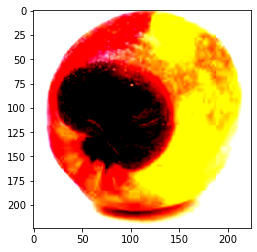

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label 2: 1


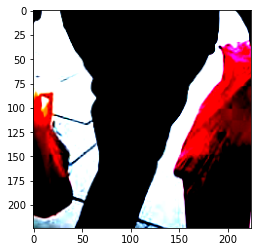

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label 3: 0


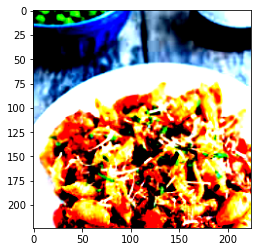

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label 4: 1


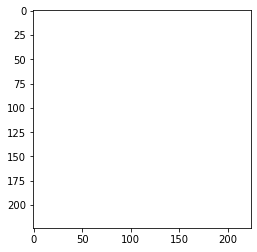

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label 5: 1


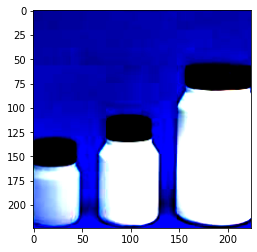

In [13]:
for i in range(5):
    train_features, train_labels = next(iter(train_dataloader))
    img = train_features[0].squeeze().numpy().transpose((1, 2, 0))

    label = train_labels[0]
    print(f"Label {i+1}: {label}")
    plt.imshow(img)
    plt.show()

## Enable GPU

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


## Construct Model

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
    
        self.conv5 = nn.Conv2d(32, 64, 3)
        self.conv6 = nn.Conv2d(64, 64, 3)
            
        self.fc1 = nn.Linear(64*24*24, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.fc4 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
net = Net().to(device)

In [16]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

## Training

We will use early stopping to get the best validation errors. this happens in 4 epochs

 Computational Graph of CNN model in TensorBoard

In [17]:
# Import the necessary library
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter
writer = SummaryWriter(log_dir="F:/UWL Study Documents/Dissertation/Dataset1_Logs")  

In [18]:
import tensorflow as tf

# Define the path to log directory
log_dir = "F:/UWL Study Documents/Dissertation/Dataset1_Logs"

# Create a summary writer
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
train_loss = []
val_loss = []
epochs = 4
train_steps = len(train_dataloader)
valid_steps = len(valid_dataloader)
for epoch in range(epochs): 
    epoch_loss = 0.0
    epoch_loss_val = 0.0
    running_loss = 0.0
    print('Training:')
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].float().to(device)

        optimizer.zero_grad()

        outputs = net(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            loss = running_loss / 10
            epoch_loss += loss
            print(f'\t[{epoch + 1}, {i + 1:5d}] loss: {loss:.6f}')
            running_loss = 0.0
     
    print('Validation:')
    running_loss_valid = 0.0
    for i, data in enumerate(valid_dataloader, 0):
        with torch.no_grad():
            inputs, labels = data[0].to(device), data[1].float().to(device)

            outputs = net(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss_valid += loss.item()
            if i % 10 == 9:
                loss = running_loss_valid / 10
                epoch_loss_val += loss
                print(f'\t[{epoch + 1}, {i + 1:5d}] loss: {loss:.6f}')
                running_loss_valid = 0.0
                
            # Log learning rate
            current_lr = optimizer.param_groups[0]['lr']
            writer.add_scalar("Learning Rate", current_lr, epoch * len(train_dataloader) + i)
            
            # Log histograms of model parameters
            if i % 10 == 9:
                for name, param in net.named_parameters():
                    writer.add_histogram(name, param, epoch * len(train_dataloader) + i)
                
    train_loss.append(epoch_loss)
    val_loss.append(epoch_loss_val)

print('Finished Training and Validation')

if i % 10 == 9:
    writer.add_graph(net, inputs)

# Close the writer
writer.close()

Training:
	[1,    10] loss: 0.687215
	[1,    20] loss: 0.664950
	[1,    30] loss: 0.624257
	[1,    40] loss: 0.546994
	[1,    50] loss: 0.500395
	[1,    60] loss: 0.441084
	[1,    70] loss: 0.407884
	[1,    80] loss: 0.516479
	[1,    90] loss: 0.450007
	[1,   100] loss: 0.409865
	[1,   110] loss: 0.449562
	[1,   120] loss: 0.396103
	[1,   130] loss: 0.455552
	[1,   140] loss: 0.429867
	[1,   150] loss: 0.412052
	[1,   160] loss: 0.424602
	[1,   170] loss: 0.423666
	[1,   180] loss: 0.458871
	[1,   190] loss: 0.432385
	[1,   200] loss: 0.418016
	[1,   210] loss: 0.407038
	[1,   220] loss: 0.463197
	[1,   230] loss: 0.455293
	[1,   240] loss: 0.440288
	[1,   250] loss: 0.417530
	[1,   260] loss: 0.457723
	[1,   270] loss: 0.387823
	[1,   280] loss: 0.444428
	[1,   290] loss: 0.375910
	[1,   300] loss: 0.427030
	[1,   310] loss: 0.402274
Validation:
	[1,    10] loss: 0.430732
	[1,    20] loss: 0.390396
	[1,    30] loss: 0.419006
Training:
	[2,    10] loss: 0.393705
	[2,    20] loss: 0.467

In [20]:
# Calculating training loss and adding it to TensorBoard
train_loss.append(epoch_loss)
writer.add_scalar("Loss/Train", epoch_loss, epoch)

In [21]:
# Calculating validation loss and adding it to TensorBoard
val_loss.append(epoch_loss_val)
writer.add_scalar("Loss/Validation", epoch_loss_val, epoch)

In [22]:
save_path = 'cnn_model.pth'

In [23]:
# Save the trained model
torch.save(net.state_dict(), save_path)

In [24]:
print(len(train_loss))
print(len(val_loss))

5
5


In [25]:
writer.close()

## Testing

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].float().to(device)
        outputs = net(images)
        predicted = torch.round(outputs.data).squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 2513 test images: 87 %


# Random Forest

In [27]:
!pip install opencv-python

In [28]:
# Function to extract features from an image
def extract_features(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to the specified dimensions
    resized_image = cv2.resize(gray_image, (new_width, new_height))
    
    hog_features = cv2.HOGDescriptor().compute(resized_image)
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    return np.concatenate((hog_features, color_hist.flatten()))

In [29]:
# Load images and extract features
train_directory = 'F:/UWL Study Documents/Dissertation/archive/DATASET/DATASET/TRAIN'
test_directory = 'F:/UWL Study Documents/Dissertation/archive/DATASET/DATASET/TEST'
image_classes = ['O', 'R']
data = []
labels = []

data = []
labels = []

for class_name in image_classes:
    train_class_directory = os.path.join(train_directory, class_name)
    test_class_directory = os.path.join(test_directory, class_name)
    
    for image_filename in os.listdir(train_class_directory):
        image_path = os.path.join(train_class_directory, image_filename)  # Corrected image path
        features = extract_features(image_path, new_width=64, new_height=128)
        data.append(features)
        labels.append(class_name)  # Use class_name as label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [30]:
# Preprocessing
new_width, new_height = 64, 128

In [31]:
# Resize and extract features for each image
processed_data = []
for features, label in zip(X_train, y_train):
    processed_data.append((features, label))

In [32]:
# Split the processed data into features and labels
X_train_processed = [data[0] for data in processed_data]
y_train_processed = [data[1] for data in processed_data]

In [33]:
# Train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train_processed, y_train_processed)

RandomForestClassifier(random_state=42)

In [34]:
# Preprocess test data
processed_test_data = []
for features, label in zip(X_test, y_test):
    processed_test_data.append((features, label))

In [35]:
# Split the processed test data into features and labels
X_test_processed = [data[0] for data in processed_test_data]
y_test_processed = [data[1] for data in processed_test_data]

In [36]:
# Predict on the test set
y_pred = random_forest_classifier.predict(X_test_processed)

In [37]:
# Calculate accuracy
accuracy = accuracy_score(y_test_processed, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.88


              precision    recall  f1-score   support

     Organic       0.89      0.90      0.89      2553
  Recyclable       0.86      0.85      0.86      1960

    accuracy                           0.88      4513
   macro avg       0.87      0.87      0.87      4513
weighted avg       0.88      0.88      0.88      4513



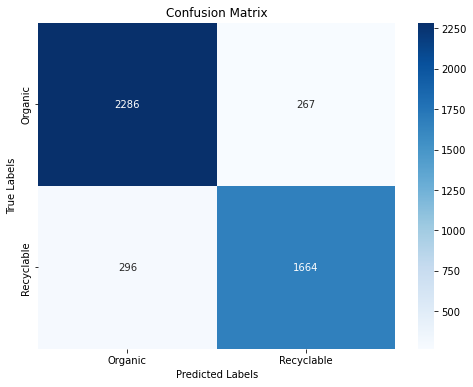

In [38]:
# Print classification report
class_names = ['Organic', 'Recyclable']
print(classification_report(y_test_processed, y_pred, target_names=class_names))


# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_processed, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Knn Algorithm

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [40]:
# Preprocessing steps
# 1. Handling missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [41]:
# 2. Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
# 3. Dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [43]:
# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  

In [44]:
# Train the classifier
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [45]:
# Predict on the test set
y_pred = knn_classifier.predict(X_test)

In [46]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


In [47]:
# Print classification report
class_names = ['Organic', 'Recyclable']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Organic       0.77      0.81      0.79      2553
  Recyclable       0.73      0.68      0.70      1960

    accuracy                           0.75      4513
   macro avg       0.75      0.74      0.75      4513
weighted avg       0.75      0.75      0.75      4513



In [48]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2067  486]
 [ 631 1329]]


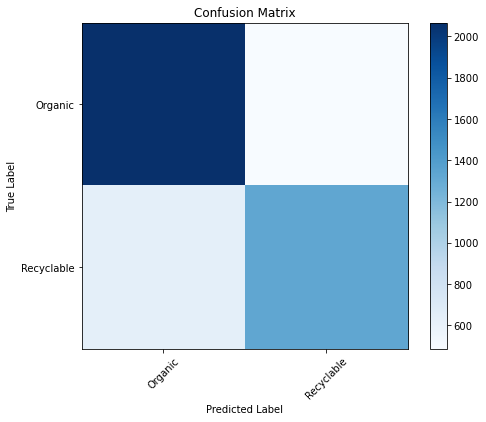

In [49]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Prediction

In [50]:
# Define the class labels
class_labels = ['Organic', 'Recyclable']

In [51]:
# Load the saved model
saved_model_path = 'cnn_model.pth'
model = Net()  # Replace 'Net' with the name of CNN class
model.load_state_dict(torch.load(saved_model_path))
model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [52]:
# Define the transformation for test images
data_transform = transforms.Compose([
    transforms.Resize((256)),
    transforms.ToTensor(),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [53]:
# Load and preprocess the test image-Input img of carrot
image_path = 'F:/UWL Study Documents/Dissertation/ds1_test_img.jpg'  
image = Image.open(image_path).convert('RGB')
image = data_transform(image).unsqueeze(0)

In [54]:
# Make a prediction
with torch.no_grad():
    output = model(image)
    predicted_class = output.round().item()  # Get the predicted class (0 or 1)

In [55]:
# Get the corresponding class label
predicted_label = class_labels[int(predicted_class)]

print(f'Predicted class: {predicted_label}')

Predicted class: Organic


Got the correct prediction for organic class so now trying for recyclable class

In [56]:
# Load and preprocess the test image-Input img of straws
image_path = 'F:/UWL Study Documents/Dissertation/ds1_test_img2.jpg'  
image = Image.open(image_path).convert('RGB')
image = data_transform(image).unsqueeze(0)

In [57]:
# Make a prediction
with torch.no_grad():
    output = model(image)
    predicted_class = output.round().item()  # Get the predicted class (0 or 1)

In [58]:
# Get the corresponding class label
predicted_label = class_labels[int(predicted_class)]

print(f'Predicted class: {predicted_label}')

Predicted class: Organic


In [59]:
# Load and preprocess the test image-Input img of can
image_path = 'F:/UWL Study Documents/Dissertation/ds1_test_img3.jpg'  
image = Image.open(image_path).convert('RGB')
image = data_transform(image).unsqueeze(0)

In [60]:
# Make a prediction
with torch.no_grad():
    output = model(image)
    predicted_class = output.round().item()  # Get the predicted class (0 or 1)

In [61]:
# Get the corresponding class label
predicted_label = class_labels[int(predicted_class)]

print(f'Predicted class: {predicted_label}')

Predicted class: Recyclable
